In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import random
import string
import tensorflow as tf
from tensorflow.python.ops.rnn_cell import _linear
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
import collections
import matplotlib.pyplot as plt
import codecs
import time
import os
import gc
from six.moves import cPickle as pickle

from plot_module import text_plot
from plot_module import structure_vocabulary_plots
from plot_module import ComparePlots

from model_module import maybe_download
from model_module import read_data
from model_module import check_not_one_byte
from model_module import id2char
from model_module import char2id
from model_module import BatchGenerator
from model_module import characters
from model_module import batches2string
from model_module import logprob
from model_module import sample_distribution
from model_module import MODEL

In [2]:
if not os.path.exists('enwik8_filtered'):
    if not os.path.exists('enwik8'):
        filename = maybe_download('enwik8.zip', 36445475)
    full_text = read_data(filename)
    new_text = u""
    new_text_list = list()
    for i in range(len(full_text)):
        if (i+1) % 10000000 == 0:
            print("%s characters are filtered" % i)
        if ord(full_text[i]) < 256:
            new_text_list.append(full_text[i])
    text = new_text.join(new_text_list)
    del new_text_list
    del new_text
    del full_text

    (not_one_byte_counter, min_character_order_index, max_character_order_index, number_of_characters, present_characters_indices) = check_not_one_byte(text)

    print("number of not one byte characters: ", not_one_byte_counter) 
    print("min order index: ", min_character_order_index)
    print("max order index: ", max_character_order_index)
    print("total number of characters: ", number_of_characters)
    
    f = open('enwik8_filtered', 'w')
    f.write(text.encode('utf8'))
    f.close()
    
else:
    f = open('enwik8_filtered', 'r')
    text = f.read().decode('utf8')
    f.close() 
    (not_one_byte_counter, min_character_order_index, max_character_order_index, number_of_characters, present_characters_indices) = check_not_one_byte(text)

    print("number of not one byte characters: ", not_one_byte_counter) 
    print("min order index: ", min_character_order_index)
    print("max order index: ", max_character_order_index)
    print("total number of characters: ", number_of_characters)    

number of not one byte characters:  0
min order index:  9
max order index:  255
total number of characters:  196


In [3]:
#different
offset = 12000
valid_size = 22500
valid_text = text[offset:offset+valid_size]
train_text = text[offset+valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99345500 nists]] such as [[Jenny d'Héricourt]] and [[Juliette Adam]] crit
22500 accordance with principles of equality and justice. 

Proudhon's


In [4]:
vocabulary_size = number_of_characters
vocabulary = list()
characters_positions_in_vocabulary = list()

character_position_in_vocabulary = 0
for i in range(256):
    if present_characters_indices[i]:
        vocabulary.append(unichr(i))
        characters_positions_in_vocabulary.append(character_position_in_vocabulary)
        character_position_in_vocabulary += 1
    else:
        characters_positions_in_vocabulary.append(-1)


string_vocabulary = u""
for i in range(vocabulary_size):
    string_vocabulary += vocabulary[i]
print("Vocabulary: ", string_vocabulary)
print("char2id(u'a') = %s,  char2id(u'z') = %s,  char2id(u' ') = %s" % (char2id(u'a', characters_positions_in_vocabulary),
                                                                        char2id(u'z', characters_positions_in_vocabulary),
                                                                        char2id(u' ', characters_positions_in_vocabulary)))
print("id2char(78) = %s,  id2char(156) = %s,  id2char(140) = %s" % (id2char(78,
                                                                            vocabulary),
                                                                    id2char(156,
                                                                            vocabulary),
                                                                    id2char(140,
                                                                            vocabulary)))


Vocabulary:  	
 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ ¡¢£¤¥¦§¨©ª«¬­®¯°±²³´µ¶·¸¹º»¼½¾¿ÀÁÂÃÄÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖ×ØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõö÷øùúûüýþÿ
char2id(u'a') = 67,  char2id(u'z') = 92,  char2id(u' ') = 2
id2char(78) = l,  id2char(156) = Ø,  id2char(140) = È


In [5]:
batch_size_test=64
num_unrollings_test=10

train_batches_test = BatchGenerator(train_text,
                                    batch_size_test,
                                    vocabulary_size,
                                    characters_positions_in_vocabulary,
                                    num_unrollings_test)
valid_batches_test = BatchGenerator(valid_text,
                                    1,
                                    vocabulary_size,
                                    characters_positions_in_vocabulary,
                                    1)

print(batches2string(train_batches_test.next(), vocabulary))
print(batches2string(train_batches_test.next(), vocabulary))
print(batches2string(valid_batches_test.next(), vocabulary))
print(batches2string(valid_batches_test.next(), vocabulary))

[u'nists]] suc', u', the word ', u'nt>\n      <', u'ile neoclas', u'Arminius ta', u'laric I tak', u'uld be used', u'orgeries wr', u'NR) ratios ', u'onstituency', u'l-Intercept', u'upporting t', u" ''Doorgame", u'\n[[Sodium b', u'[Gadianton ', u' always pos', u'ence paid o', u' from the l', u'al, it was ', u"lizzard's [", u' is a subse', u'uro Alessan', u' upon enter', u' Caesar, fo', u"he nation's", u' inaugurate', u'|\nyear=2004', u"onicle's cl", u"'Mrs. Warre", u'e Just.  Dr', u'1989, the F', u'South India', u'sh:\n- rhoti', u'8 december]', u'ct, [[Recoi', u'ril 2003: D', u'raadelst.bh', u'ed the resu', u'ad created ', u'eans that p', u'es Wide Shu', u'al knowledg', u'ot describe', u'ged, includ', u't;1&lt;/sub', u"'' issue da", u'/&gt; [[Bra', u'escribed as', u'the [[Greek', u'humb|Waterf', u'es of the G', u'he Azerbaij', u'medieval [[', u'nter-Reform', u'in the audi', u' [[1390]] h', u' government', u'of Parliame', u' comprise t', u'ss. With th', u'erves as an', u'\n**[[IUPUI|', u'

In [6]:



class random_choice(MODEL):
    def layer(self, 
              inp_t,
              state_t_minus_1,
              memory_t_minus_1):
        X_t = tf.concat(1, [inp_t,
                            state_t_minus_1,
                            memory_t_minus_1])
        RES = tf.matmul(X_t, self.Matrix) + self.Bias
        state_t = tf.tanh(RES)
        return state_t

    def swap_layer(self, 
                   inp_t,
                   new_state,
                   new_memory,
                   old_state,
                   old_memory):
        new_x = tf.concat(1, [inp_t, new_state, new_memory])
        old_x = tf.concat(1, [inp_t, old_state, old_memory])
        x = tf.concat(0, [new_x, old_x])
        output = tf.tanh(tf.matmul(x, self.Matrix) + self.Bias)
        return tf.split(0, 2, output)

    
    def iteration(self, inp, state):
        
        output = self.layer(inp,
                            state[0],
                            state[1])
        trigger = tf.sigmoid(tf.matmul(tf.concat(1, [inp, output, state[1]]), self.trigger_matrix) + self.trigger_bias)
        trigger = tf.reshape(trigger, [-1])
        current_batch_size = trigger.get_shape().as_list()[0]
        swap = tf.greater(trigger, self.thresh)
        output_coef = tf.to_float(swap)
        memory_coef = tf.constant(1., shape=[current_batch_size])
        memory_coef = memory_coef - output_coef
        memory = tf.transpose(output_coef * tf.transpose(output) + memory_coef * tf.transpose(state[1]))
        return output, output, [output, memory, output, memory], trigger, tf.slice(output_coef, [0], [1]), tf.slice(memory_coef, [0], [1])
    
    def swap_iteration(self, inp, state, input_idx):
        [output, old_output] = self.swap_layer(inp,
                                               state[0],
                                               state[1],
                                               state[2],
                                               state[3])
        trigger = tf.sigmoid(tf.matmul(tf.concat(1, [inp, output, state[1]]), self.trigger_matrix) + self.trigger_bias)
        swap_prob = tf.constant(self._swap_prob) 
        swap = tf.less(tf.random_uniform([1])[0], swap_prob)
        if input_idx != self._num_unrollings-1:
            coef_output = tf.to_float(swap)
        else:
            coef_output = tf.constant(1.)
        coef_memory = tf.constant(1.) - coef_output
        new_memory = coef_output * output + coef_memory * state[1] 
        if input_idx != self._num_unrollings-1:
            old_memory = coef_output * state[1] + coef_memory * state[3]
            old_output = coef_output * output + coef_memory * old_output
        else:
            old_memory = new_memory
            old_output = output
        return output, old_output, [output, new_memory, old_output, old_memory], tf.reshape(trigger, [-1]), coef_output, coef_memory
    
    def unrollings(self, train_inputs, saved_state):
        outputs = list()
        old_outputs = list()
        state = saved_state
        triggers = list()
        output_coefs = list()
        memory_coefs = list()
        for inp in train_inputs:
            output, old_output, state, current_trigger, output_coef, memory_coef = self.iteration(inp, state)
            outputs.append(output)  
            old_outputs.append(old_output)
            triggers.append(current_trigger)
            output_coefs.append(output_coef)
            memory_coefs.append(memory_coef)
        return [tf.concat(0, outputs),
                tf.concat(0, old_outputs),
                tf.concat(0, state),
                tf.concat(0, triggers),
                tf.concat(0, output_coefs),
                tf.concat(0, memory_coefs)]
    
    def swap_unrollings(self, train_inputs, saved_state):
        outputs = list()
        old_outputs = list()
        state = saved_state
        triggers = list()
        output_coefs = list()
        memory_coefs = list()
        for idx, inp in enumerate(train_inputs):
            output, old_output, state, current_trigger, output_coef, memory_coef = self.swap_iteration(inp, state, idx)
            outputs.append(output) 
            old_outputs.append(old_output)
            if idx == 0:
                triggers.append(current_trigger)
            else:
                triggers.append(output_coef * current_trigger + memory_coef * triggers[-1])
            output_coefs.append(output_coef)
            memory_coefs.append(memory_coef)
        return [tf.concat(0, outputs),
                tf.concat(0, old_outputs),
                tf.concat(0, state),
                tf.concat(0, triggers),
                tf.pack(output_coefs),
                tf.pack(memory_coefs)]


    def __init__(self,
                 batch_size,
                 vocabulary,
                 characters_positions_in_vocabulary,
                 num_unrollings,
                 num_layers,
                 num_nodes,
                 init_bias,
                 threshold,    #{'fixed': True/False, 'min':  , 'max':  ,'epochs':  }
                 normal_run_prob,
                 swap_prob,
                 support,
                 train_text,
                 valid_text,
                 mean=0.,
                 stddev='default',
                 shift=0.,
                 init_learning_rate=1.):
        self._results = list()
        self._batch_size = batch_size
        self._vocabulary = vocabulary
        self._vocabulary_size = len(vocabulary)
        self._characters_positions_in_vocabulary = characters_positions_in_vocabulary
        self._num_unrollings = num_unrollings
        self._num_layers = num_layers
        self._num_nodes = num_nodes
        self._init_bias = init_bias
        self._threshold = threshold
        self._normal_run_prob = normal_run_prob
        self._swap_prob = swap_prob
        self._support = support
        self._train_text = train_text
        self._valid_text = valid_text
        self._valid_size = len(valid_text)
        
        
        self._mean = mean
        
        self._stddev = list()
        if stddev == 'default':
            self._stddev = 1.0 * np.sqrt(1./(2*num_nodes[0] + vocabulary_size))
        else:
            self._stddev = stddev
            
        self._shift = shift
        self._init_learning_rate = init_learning_rate
        
        self._indices = {"batch_size": 0,
                         "num_unrollings": 1,
                         "num_layers": 2,
                         "num_nodes": 3,
                         "half_life": 4,
                         "decay": 5,
                         "num_steps": 6,
                         "averaging_number": 7,
                         "init_bias": 8,
                         "threshold": 9,
                         "normal_run_prob": 10,
                         "swap_prob": 11,
                         "support": 12,
                         "memory_fine":13,
                         "init_mean": 14,
                         "init_stddev": 15,
                         "init_shift": 16,
                         "init_learning_rate": 17,
                         "type": 18}
        self._graph = tf.Graph()
        
        self._last_num_steps = 0
        with self._graph.as_default(): 
            with self._graph.device('/gpu:0'): 
                self.Matrix = tf.Variable(tf.truncated_normal([self._vocabulary_size + 2*self._num_nodes[0],
                                                               self._num_nodes[0]],
                                                              mean=self._mean, stddev=self._stddev))
                self.Bias = tf.Variable([self._shift for _ in range(self._num_nodes[0])])

                # classifier 
                weights = tf.Variable(tf.truncated_normal([self._num_nodes[-1], self._vocabulary_size], stddev = 0.1))
                bias = tf.Variable(tf.zeros([self._vocabulary_size]))
                
                self.trigger_matrix = tf.Variable(tf.truncated_normal([self._vocabulary_size + 2 * self._num_nodes[0], 1], stddev = 0.1))
                self.trigger_bias = tf.Variable([self._init_bias])
                
                """PLACEHOLDERS train data"""
                self._train_data = list()
                for _ in range(self._num_unrollings + 1):
                    self._train_data.append(
                        tf.placeholder(tf.float32, shape=[self._batch_size, self._vocabulary_size]))
                train_inputs = self._train_data[: self._num_unrollings]
                train_labels = self._train_data[1:]  # labels are inputs shifted by one time step.
                # Unrolled LSTM loop.

                saved_state = [tf.Variable(tf.zeros([self._batch_size, self._num_nodes[0]]), trainable=False),
                               tf.Variable(tf.zeros([self._batch_size, self._num_nodes[0]]), trainable=False),
                               tf.Variable(tf.zeros([self._batch_size, self._num_nodes[0]]), trainable=False),
                               tf.Variable(tf.zeros([self._batch_size, self._num_nodes[0]]), trainable=False)]
                
                """global step"""
                self._global_step = tf.Variable(0)
                
                normal_prob = tf.minimum(
                    tf.constant(self._normal_run_prob['init']) + tf.to_float(self._global_step) / self._normal_run_prob['epochs'] * tf.constant(1. - self._normal_run_prob['init']),
                    tf.constant(1.))
                """swap"""
                swap = tf.greater(tf.random_uniform([1])[0], normal_prob) 
                """self.thresh"""
                if self._threshold['fixed']:
                    self.thresh = tf.constant(self._threshold['min'])
                else:
                    thresh_range = self._threshold['max'] - self._threshold['min']
                    self.thresh = tf.minimum(tf.constant(self._threshold['min']) + tf.to_float(self._global_step) / self._threshold['epochs'] * tf.constant(thresh_range), tf.constant(self._threshold['max']))
                state = saved_state
            

                [self.outputs, old_outputs, state, current_trigger, out_coefs, mem_coefs] = tf.cond(swap,
                                                                                                    lambda: self.swap_unrollings(train_inputs, state),
                                                                         lambda: self.unrollings(train_inputs, state))
                coef_print = tf.pack([out_coefs, mem_coefs])
                self.coef_print = tf.transpose(coef_print)

                state = tf.split(0, 4, state)
                save_list = list()
                
                save_list.append(saved_state[0].assign(state[0]))
                save_list.append(saved_state[1].assign(state[1]))
                save_list.append(saved_state[2].assign(state[2]))
                save_list.append(saved_state[3].assign(state[3]))
                
                """skip operation"""
                self._skip_operation = tf.group(*save_list)
                
                self.memory_fine = tf.placeholder(tf.float32)
                mf = tf.minimum(tf.to_float(swap), self.memory_fine)
                current_trigger = mf * current_trigger
                """self.ch = tf.minimum(tf.constant(1.) - tf.to_float(swap), self.memory_fine)"""
                with tf.control_dependencies(save_list):
                        # Classifier.
                    self.new_logits = tf.nn.xw_plus_b(self.outputs, weights, bias)
                    old_logits = tf.nn.xw_plus_b(old_outputs, weights, bias)
                    new_loss = tf.nn.softmax_cross_entropy_with_logits(
                        self.new_logits, tf.concat(0, train_labels))
                    old_loss = tf.nn.softmax_cross_entropy_with_logits(
                        old_logits, tf.concat(0, train_labels))
                    """loss"""
                    self._loss = tf.reduce_mean(new_loss)
                    trigger_loss = tf.reduce_sum(((1. + self._support / 100) * new_loss - old_loss) * current_trigger)
                    """trigger_loss = tf.reduce_sum(-0.001*current_trigger*self.ch)"""

                # Optimizer.
                
                """PLACEHOLDERS half life and decay"""
                self._half_life = tf.placeholder(tf.int32)
                self._decay = tf.placeholder(tf.float32)
                """learning rate"""
                self._learning_rate = tf.train.exponential_decay(self._init_learning_rate,
                                                                 self._global_step,
                                                                 self._half_life,
                                                                 self._decay,
                                                                 staircase=True)
                optimizer = tf.train.GradientDescentOptimizer(self._learning_rate)
                
                trigger_vars = [self.trigger_matrix, self.trigger_bias]
                other_vars = [self.Matrix, self.Bias, weights, bias]
                
                trigger_grads, trigger_vars = zip(*optimizer.compute_gradients(trigger_loss, var_list=trigger_vars))
                other_grads, other_vars = zip(*optimizer.compute_gradients(self._loss, var_list=other_vars))

                gradients = list(other_grads)
                gradients.extend(list(trigger_grads))
                v = list(other_vars)
                v.extend(list(trigger_vars))
                gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
                """optimizer"""
                self._optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=self._global_step)
                """train prediction"""
                self._train_prediction = tf.nn.softmax(self.new_logits)

                # Sampling and validation eval: batch 1, no unrolling.
                saved_sample_state = list()
                saved_sample_state.append(tf.Variable(tf.zeros([1, self._num_nodes[0]]), trainable=False)) 
                saved_sample_state.append(tf.Variable(tf.zeros([1, self._num_nodes[0]]), trainable=False)) 
                saved_sample_state.append(tf.Variable(tf.zeros([1, self._num_nodes[0]]), trainable=False)) 
                saved_sample_state.append(tf.Variable(tf.zeros([1, self._num_nodes[0]]), trainable=False)) 
                """PLACEHOLDER sample input"""
                self._sample_input = tf.placeholder(tf.float32, shape=[1, self._vocabulary_size])

                reset_list = list()
                reset_list.append(saved_sample_state[0].assign(tf.zeros([1, self._num_nodes[0]])))
                reset_list.append(saved_sample_state[1].assign(tf.zeros([1, self._num_nodes[0]])))
                reset_list.append(saved_sample_state[2].assign(tf.zeros([1, self._num_nodes[0]])))
                reset_list.append(saved_sample_state[3].assign(tf.zeros([1, self._num_nodes[0]])))

                """reset sample state"""
                self._reset_sample_state = tf.group(*reset_list)
                
                """trigger"""
                sample_output, _, sample_state, self.trigger, _, _ = self.iteration(self._sample_input, saved_sample_state)
                
                self.trigger = tf.reshape(self.trigger, [1, 1])
                sample_save_list = list()
                sample_save_list.append(saved_sample_state[0].assign(sample_state[0]))
                sample_save_list.append(saved_sample_state[1].assign(sample_state[1]))
                sample_save_list.append(saved_sample_state[2].assign(sample_state[2]))
                sample_save_list.append(saved_sample_state[3].assign(sample_state[3]))

                with tf.control_dependencies(sample_save_list):
                    """sample prediction"""
                    self._sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, weights, bias)) 
                
                
                """saver"""
                self.saver = tf.train.Saver(max_to_keep=None)
                            
                        
    
    def _generate_metadata(self, half_life, decay, num_averaging_iterations, memory_fine):
        metadata = list()
        metadata.append(self._batch_size)
        metadata.append(self._num_unrollings)
        metadata.append(self._num_layers)
        metadata.append(self._num_nodes)
        metadata.append(half_life)
        metadata.append(decay)
        metadata.append(self._last_num_steps)
        metadata.append(num_averaging_iterations)
        metadata.append(self._init_bias)
        metadata.append(dict(self._threshold))
        metadata.append(dict(self._normal_run_prob))
        metadata.append(self._swap_prob)
        metadata.append(self._support)
        metadata.append(memory_fine)
        metadata.append(self._mean)
        metadata.append(self._stddev)
        metadata.append(self._shift)
        metadata.append(self._init_learning_rate)
        metadata.append('random_choice')
        return metadata
  
    def get_triggers(self, session, num_strings=10, length=75, start_positions=None):
        self._reset_sample_state.run()
        self._valid_batches = BatchGenerator(self._valid_text,
                                             1,
                                             self._vocabulary_size,
                                             self._characters_positions_in_vocabulary,
                                             1)
        if start_positions is None:
            start_positions = list()
            if self._valid_size / num_strings < length:
                num_strings = self._valid_size / length
            for i in range(num_strings):
                start_positions.append(i* (self._valid_size / num_strings) + self._valid_size / num_strings / 2)
            while self._valid_size - start_positions[-1] < length:
                del start_positions[-1]
        text_list = list()
        trigger_list = list()
        collect_triggers = False
        letters_parsed = -1
        for idx in range(self._valid_size):
            b = self._valid_batches.next()
            
            if idx in start_positions or collect_triggers: 
                if letters_parsed == -1:
                    letters_parsed = 0
                    text = u""
                    t_list = list()
                    collect_triggers = True
                text += characters(b[0], self._vocabulary)[0]
                t_list.append(self.trigger.eval({self._sample_input: b[0]}))
                letters_parsed += 1
                if letters_parsed >= length:
                    collect_triggers = False
                    trigger_list.append(t_list)
                    text_list.append(text)
                    letters_parsed = -1
                    
            _ = self._sample_prediction.eval({self._sample_input: b[0]})
        return text_list, trigger_list 

In [7]:
threshold = {'fixed': True, 'min': 0.5, 'max': 0.7, 'epochs': 10000}
normal_run_prob = {'init': 0.1, 'epochs': 10000}

model = random_choice(64,
                 vocabulary,
                 characters_positions_in_vocabulary,
                 30,
                 1,
                 [128],
                 0.,
                 threshold,    #{'fixed': True/False, 'min':  , 'max':  ,'epochs':  }
                 normal_run_prob,
                      0.39,
                        0.1,
                 train_text,
                 valid_text)

In [8]:
optional_feed_dict = {'self.memory_fine': 0.01}
model.simple_run(100,
                'random_choice/variables/swpr0.1_sp0.0039_nu30_ns10k_th%s_mf%s' % (threshold['min'], optional_feed_dict['self.memory_fine']),
                10000,
                400,
                5000,        #learning has a chance to be stopped after every block of steps
                30,
                0.9,
                3,
                optional_feed_dict=optional_feed_dict)

Number of steps = 10001     Percentage = 44.92%     Time = 636s     Learning rate = 0.0424


In [9]:
text_list, trigger_list = model.run_for_analitics(model.get_triggers,
                                                'random_choice/variables/swpr0.1_sp0.0039_nu30_ns10k_th%s_mf%s' % (threshold['min'], optional_feed_dict['self.memory_fine']),
                                                [100, 75, None])
triggers = list()
for text_number, text in enumerate(text_list):
    trig = list()
    text_triggers = trigger_list[text_number]
    for text_trigger in text_triggers:
        trig.append(text_trigger[0, 0])
    triggers.append(trig)
structure_vocabulary_plots(text_list,
                                   triggers,
                                   'triggers for letter position (threshold %s, memory fine %s)'% (threshold['min'], optional_feed_dict['self.memory_fine']),
                           'mean trigger',        
                           ['random_choice', 'swpr0.1_sp0.0039_nu30_ns10k', 'vocabulary_plots'],
                                   'mean_triggers128_ib0_th%s_mf%s' % (threshold['min'], optional_feed_dict['self.memory_fine']),
                                   show=False)
for i in range(99):
    text_plot(text_list[i],
                triggers[i],
                'trigger',
                'triggers (threshold %s, memory fine %s)' % (threshold['min'], optional_feed_dict['self.memory_fine']),
                ['random_choice', 'swpr0.1_sp0.0039_nu30_ns10k', 'text_plots','th%s_mf%s' % (threshold['min'], optional_feed_dict['self.memory_fine'])],
                'triggers128_ib0_th%s_mf%s#%s' % (threshold['min'], optional_feed_dict['self.memory_fine'], i),
                show=False)

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


IndexError: list index out of range

In [40]:
optional_feed_dict = {'self.memory_fine': 0.0000001}
model.run(30,
          0.9,
            200,
            50,
            3,
            1,
            20,
          optional_feed_dict=optional_feed_dict,
            print_intermediate_results = True,
          add_operation='self.ch')

Initialized
0   self.ch = 0.0
Average loss at step 0: 5.283191 learning rate: 1.000000
Percentage_of correct: 0.00%

random:
1 /îËúº ¶/òu5Ó¤ú"½*«@¸íR2¸9­=½ð"ãÆ&fOÏ/¥ãU'a^4Û6é&©d/ô
(Î_-` 9pÔaüðâ5::ã Ñ)õ1Á;
Ô·±9¶ø9þ{â×@à®ìc/HÝk¾ÝÊµMÒrc£Ûç´® Û@¸@	bp dês­h?ópSì  Ï;ëDÕß	üH­{ð·1Uã¤0·Ë£´ã=¢²
´&Ü(ôeòð/bË
¦íÅð×WBÔ3¶UòrW«î]3PCO!á8Iýðu'jÂÉdy­À£^chá8GW*uCØlXz~-yëd¶µÊöå®sÚX
 å¸63<YOj¹ÁB §]E×Yã,ûãS­ ö7I¤\éñbÁ.øVDÈïÐÈdáþ»l+HO£¨Rá~ß ëëÝg¬Y£2Íc¨¶ú¾N¸´í÷Px÷
3\N& ÜÐÍgË«Q7ªk?J[`ßÛlÀàÏr?µèí`þ5ÿ(kI.ÐîkÿhLbXsvdþä d9tH"Ç?³DÎ"`ùÔHikµ(ë¦Kùy
Validation percentage of correct: 12.14%

1   self.ch = 0.0
2   self.ch = 0.0
3   self.ch = 0.0
4   self.ch = 0.0
5   self.ch = 0.0
6   self.ch = 0.0
7   self.ch = 0.0
8   self.ch = 0.0
9   self.ch = 0.0
10   self.ch = 0.0
11   self.ch = 0.0
12   self.ch = 1e-07
13   self.ch = 0.0
14   self.ch = 0.0
15   self.ch = 0.0
16   self.ch = 0.0
17   self.ch = 0.0
18   self.ch = 0.0
19   self.ch = 0.0
20   self.ch = 1e-07


KeyboardInterrupt: 

In [24]:
normal_run_prob = {'init': 0.1, 'epochs': 15000}

memory_fine_values = [1., 0.1, 0.01, 0.001]
support_values = [-0.06 - i  * 0.04 for i in range(6)]
swap_probability_values = [0.2, 0.14, 0.1, 0.07, 0.05, 0.03]

threshold = {'fixed': True, 'min': 0.5, 'max': 0.7, 'epochs': 10000}
optional_feed_dict = {'self.memory_fine': 0.001}
results_GL = list()

for memory_fine_value in memory_fine_values:
    print(' '*10, "memory fine: ", memory_fine_value)
    optional_feed_dict['self.memory_fine'] = memory_fine_value
    for support_value in support_values:
        print(' '*5, "support: ", support_value)
        for swap_value in swap_probability_values:
            print("swap probability: ", swap_value)
            model = random_choice(64,
                                 vocabulary,
                                 characters_positions_in_vocabulary,
                                 30,
                                 1,
                                 [128],
                                 0.,
                                 threshold,    #{'fixed': True/False, 'min':  , 'max':  ,'epochs':  }
                                        normal_run_prob,
                                 swap_value,
                                  support_value,
                                 train_text,
                                 valid_text)
            model.simple_run(100,
                               'random_choice/variables/negative_support2/sw%s_sp%s_mf%s' % (swap_value, support_value, memory_fine_value),
                               20000,
                               4000,
                               5000,        #learning has a chance to be stopped after every block of steps
                               30,
                               0.9,
                               3,
                               optional_feed_dict=optional_feed_dict,
                             fixed_num_steps=True)
            results_GL.extend(model._results)
            model.destroy()
            del model
            gc.collect()

           memory fine:  1.0
      support:  -0.06
swap probability:  0.2
Number of steps = 20000     Percentage = 47.72%     Time = 1192s     Learning rate = 0.0424
swap probability:  0.14
Number of steps = 20000     Percentage = 47.50%     Time = 1196s     Learning rate = 0.0424
swap probability:  0.1
Number of steps = 20000     Percentage = 47.36%     Time = 1194s     Learning rate = 0.0424
swap probability:  0.07
Number of steps = 20000     Percentage = 47.33%     Time = 1198s     Learning rate = 0.0424
swap probability:  0.05
Number of steps = 20000     Percentage = 47.15%     Time = 1192s     Learning rate = 0.0424
swap probability:  0.03
Number of steps = 20000     Percentage = 47.35%     Time = 1191s     Learning rate = 0.0424
      support:  -0.1
swap probability:  0.2
Number of steps = 20000     Percentage = 47.43%     Time = 1204s     Learning rate = 0.0424
swap probability:  0.14
Number of steps = 20000     Percentage = 47.41%     Time = 1195s     Learning rate = 0.0424
swa

In [25]:
folder_name = 'random_choice'
file_name = 'random_choice_ns_20000_hl_667_dc_0.9_ib0_ilr1._th0.5_mf1-0.001_swpr0.2-0.03_sp-0.06--0.26_0.1.pickle'
force = True
pickle_dump = {'results_GL': results_GL}
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except Exception as e:
        print("Unable create folder '%s'" % folder_name, ':', e)    
print('Pickling %s.' % (folder_name + '/' + file_name))
try:
    with open(folder_name + '/' + file_name, 'wb') as f:
        pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', file_name, ':', e)

Pickling random_choice/random_choice_ns_20000_hl_667_dc_0.9_ib0_ilr1._th0.5_mf1-0.001_swpr0.2-0.03_sp-0.06--0.26_0.1.pickle.


In [8]:
folder_name = 'random_choice'
file_name = 'random_choice_ns_20000_hl_667_dc_0.9_ib0_ilr1._th0.5_mf1-0.001_swpr0.2-0.03_sp0.-0.9_0.1.pickle'
force = True
pickle_dump = {'results_GL': results_GL}
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except Exception as e:
        print("Unable create folder '%s'" % folder_name, ':', e)    
print('Pickling %s.' % (folder_name + '/' + file_name))
try:
    with open(folder_name + '/' + file_name, 'wb') as f:
        pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', file_name, ':', e)

Pickling random_choice/random_choice_ns_20000_hl_667_dc_0.9_ib0_ilr1._th0.5_mf1-0.001_swpr0.2-0.03_sp0.-0.9_0.1.pickle.


In [14]:
folder_name = 'random_choice'
file_name = 'random_choice_ns_20000_hl_667_dc_0.9_ib0_ilr1._th0.5_mf1-0.001_swpr0.2-0.03_sp-0.04-0.06_0.1.pickle'
force = True
pickle_dump = {'results_GL': results_GL}
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except Exception as e:
        print("Unable create folder '%s'" % folder_name, ':', e)    
print('Pickling %s.' % (folder_name + '/' + file_name))
try:
    with open(folder_name + '/' + file_name, 'wb') as f:
        pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', file_name, ':', e)

Pickling random_choice/random_choice_ns_20000_hl_667_dc_0.9_ib0_ilr1._th0.5_mf1-0.001_swpr0.2-0.03_sp-0.04-0.06_0.1.pickle.


In [8]:
folder_name = 'random_choice'
pickle_file = 'random_choice_ns_20000_hl_667_dc_0.9_ib0_ilr1._th0.5_mf1-0.001_swpr0.2-0.03_sp-0.04-0.06_0.1.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  results_GL = save['results_GL']
  del save  # hint to help gc free up memory

In [9]:
folder_name = 'random_choice'
pickle_file = 'random_choice_ns_20000_hl_667_dc_0.9_ib0_ilr1._th0.5_mf1-0.001_swpr0.2-0.03_sp0.-0.9_0.1.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  results_GL.extend(save['results_GL'])
  del save  # hint to help gc free up memory

In [10]:
folder_name = 'random_choice'
pickle_file = 'random_choice_ns_20000_hl_667_dc_0.9_ib0_ilr1._th0.5_mf1-0.001_swpr0.2-0.03_sp-0.06--0.26_0.1.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  results_GL.extend(save['results_GL'])
  del save  # hint to help gc free up memory

In [14]:
print(results_GL[0])

{'time': 1231.363442, 'data': {'train': {'step': [-1], 'percentage': [47.14010416666666]}, 'validation': {'step': [-1], 'percentage': [44.6]}}, 'metadata': [64, 30, 1, [128], 666, 0.9, 20000, 100, 0.0, {'epochs': 10000, 'max': 0.7, 'fixed': True, 'min': 0.5}, {'epochs': 15000, 'init': 0.1}, 0.9, 0.2, 1.0, 0.0, 0.047036043419179864, 0.0, 1.0, 'random_choice']}


In [11]:
from plot_module import ComparePlots

random_choice_plots = ComparePlots('random_choice')
random_choice_plots.add_network(results_GL, model._indices)



In [12]:
random_choice_plots.save_layouts('random_choice_1',
                                 folder_list=['support_effect'],
                                 varying_variables=['support', 'memory_fine', 'swap_prob'])

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


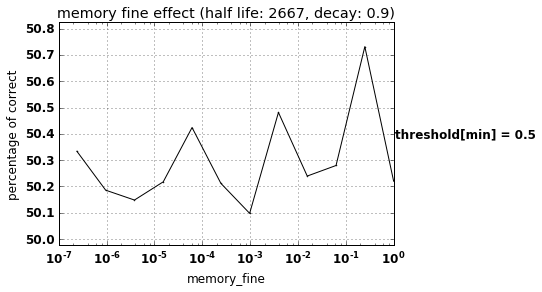

In [24]:
plot_options = {'x': 'log'}
plot_data, _ = random_choice_plots.one_key_layout_data('random_choice_1',
                                         'support',
                                         ['memory_fine', 'swap_prob'])
random_choice_plots.save_layout(plot_data[0],
                    'memory fine effect (half life: 2667, decay: 0.9)',
                    ['support_effect', 'plots'],
                    'nn128;ns80000;hl2667;dc0.9;swpr0.03',
                              plot_options=plot_options)
random_choice_plots.draw(plot_data[0], 'memory fine effect (half life: 2667, decay: 0.9)', plot_options=plot_options)

In [20]:
uppercase = [u'A', u'B', u'C', u'D', u'E', u'F', u'G', u'H', u'I', u'J', u'K', u'L', u'M', u'N', u'O', u'P', u'Q', u'R', u'S', u'T', u'U', u'V', u'W', u'X', u'Y', u'Z']
lowercase = [u'a', u'b', u'c', u'd', u'e', u'f', u'g', u'h', u'i', u'j', u'k', u'l', u'm', u'n', u'o', u'p', u'q', u'r', u's', u't', u'u', u'v', u'w', u'x', u'y', u'z']
def count_words(text):
    word_lengths = dict()
    current_length = 0
    for char in text:
        if char not in uppercase and char not in lowercase:
            if current_length != 0:
                if current_length in word_lengths.keys():
                    word_lengths[current_length] += 1
                else:
                    word_lengths[current_length] = 1
                current_length = 0
        else: 
            current_length += 1
    for length in word_lengths.keys():
        print("%s: %s" % (length, word_lengths[length]))
count_words(valid_text)

1: 113
2: 483
3: 558
4: 378
5: 291
6: 274
7: 320
8: 213
9: 262
10: 178
11: 78
12: 30
13: 40
14: 9
15: 5
16: 2
17: 1
19: 1


In [22]:
normal_run_prob = {'init': 0.1, 'epochs': 15000}

memory_fine_values = [1., 0.1, 0.01, 0.001]
support_values = [0.3 - i  * 0.03 for i in range(11)]
swap_probability_values = [0.2, 0.14, 0.1, 0.07, 0.05, 0.03]

threshold = {'fixed': True, 'min': 0.5, 'max': 0.7, 'epochs': 10000}
optional_feed_dict = {'self.memory_fine': 0.001}
results_GL = list()

for memory_fine_value in memory_fine_values:
    print(' '*10, "memory fine: ", memory_fine_value)
    optional_feed_dict['self.memory_fine'] = memory_fine_value
    for support_value in support_values:
        print(' '*5, "support: ", support_value)
        for swap_value in swap_probability_values:
            print("swap probability: ", swap_value)
            model = random_choice(64,
                                 vocabulary,
                                 characters_positions_in_vocabulary,
                                 30,
                                 1,
                                 [128],
                                 0.,
                                 threshold,    #{'fixed': True/False, 'min':  , 'max':  ,'epochs':  }
                                        normal_run_prob,
                                  support_value,
                                        swap_value,
                                 train_text,
                                 valid_text)
            text_list, trigger_list = model.run_for_analitics(model.get_triggers,
                                                        'random_choice/variables/sw%s_sp%s_mf%s' % (swap_value, support_value, memory_fine_value),
                                                        [300, 75, None])
            """check_text = ''
            check_text = check_text.join(text_list)
            count_words(check_text)"""
            triggers = list()
            for text_number, text in enumerate(text_list):
                trig = list()

                text_triggers = trigger_list[text_number]
                for text_trigger in text_triggers:
                    trig.append(text_trigger[0, 0])
                triggers.append(trig)
            structure_vocabulary_plots(text_list,
                                   triggers,
                                   'triggers (swap probability: %s; support %s%%; memory fine: %s)' % (swap_value, support_value, memory_fine_value),
                                   'mean trigger',
                                   ['random_choice', 'vocabulary_plots'],
                                   'ns20k_th0.5_ib0_sw%s_sp%s_mf%s' % (swap_value, support_value, memory_fine_value),
                                       ylims=[0., 1.],
                                       threshold=0.5,
                                   show=False)
            for i in range(50):
                text_plot(text_list[i],
                      triggers[i],
                      'trigger',
                      'triggers (swap probability: %s; support %s%%; memory fine: %s)' % (swap_value, support_value, memory_fine_value),
                      ['random_choice', 'text_plots', 'ns20k_th0.5_ib0', 'sw%s_sp%s_mf%s' % (swap_value, support_value, memory_fine_value)],
                      'ns20k_th0.5_ib0_sw%s_sp%s_mf%s#%s' % (swap_value, support_value, memory_fine_value, i),
                          threshold=0.5,
                      show=False)
            model.destroy()
            del model
            gc.collect()

           memory fine:  1.0
      support:  0.3
swap probability:  0.2
swap probability:  0.14
swap probability:  0.1
swap probability:  0.07
swap probability:  0.05
swap probability:  0.03
      support:  0.27
swap probability:  0.2
swap probability:  0.14
swap probability:  0.1
swap probability:  0.07
swap probability:  0.05
swap probability:  0.03
      support:  0.24
swap probability:  0.2
swap probability:  0.14
swap probability:  0.1
swap probability:  0.07
swap probability:  0.05
swap probability:  0.03
      support:  0.21
swap probability:  0.2
swap probability:  0.14
swap probability:  0.1
swap probability:  0.07
swap probability:  0.05
swap probability:  0.03
      support:  0.18
swap probability:  0.2
swap probability:  0.14
swap probability:  0.1
swap probability:  0.07
swap probability:  0.05
swap probability:  0.03
      support:  0.15
swap probability:  0.2
swap probability:  0.14
swap probability:  0.1
swap probability:  0.07
swap probability:  0.05
swap probability: 

In [23]:
normal_run_prob = {'init': 0.1, 'epochs': 15000}

memory_fine_values = [1., 0.1, 0.01, 0.001]
support_values = [-0.04, -0.02, 0.02, 0.04]
swap_probability_values = [0.2, 0.14, 0.1, 0.07, 0.05, 0.03]

threshold = {'fixed': True, 'min': 0.5, 'max': 0.7, 'epochs': 10000}
optional_feed_dict = {'self.memory_fine': 0.001}
results_GL = list()

for memory_fine_value in memory_fine_values:
    print(' '*10, "memory fine: ", memory_fine_value)
    optional_feed_dict['self.memory_fine'] = memory_fine_value
    for support_value in support_values:
        print(' '*5, "support: ", support_value)
        for swap_value in swap_probability_values:
            print("swap probability: ", swap_value)
            model = random_choice(64,
                                 vocabulary,
                                 characters_positions_in_vocabulary,
                                 30,
                                 1,
                                 [128],
                                 0.,
                                 threshold,    #{'fixed': True/False, 'min':  , 'max':  ,'epochs':  }
                                        normal_run_prob,
                                  support_value,
                                        swap_value,
                                 train_text,
                                 valid_text)
            text_list, trigger_list = model.run_for_analitics(model.get_triggers,
                                                        'random_choice/variables/negative_support1/sw%s_sp%s_mf%s' % (swap_value, support_value, memory_fine_value),
                                                        [300, 75, None])
            """check_text = ''
            check_text = check_text.join(text_list)
            count_words(check_text)"""
            triggers = list()
            for text_number, text in enumerate(text_list):
                trig = list()

                text_triggers = trigger_list[text_number]
                for text_trigger in text_triggers:
                    trig.append(text_trigger[0, 0])
                triggers.append(trig)
            structure_vocabulary_plots(text_list,
                                   triggers,
                                   'triggers (swap probability: %s; support %s%%; memory fine: %s)' % (swap_value, support_value, memory_fine_value),
                                   'mean trigger',
                                   ['random_choice', 'vocabulary_plots'],
                                   'ns20k_th0.5_ib0_sw%s_sp%s_mf%s' % (swap_value, support_value, memory_fine_value),
                                       ylims=[0., 1.],
                                       threshold=0.5,
                                   show=False)
            for i in range(50):
                text_plot(text_list[i],
                      triggers[i],
                      'trigger',
                      'triggers (swap probability: %s; support %s%%; memory fine: %s)' % (swap_value, support_value, memory_fine_value),
                      ['random_choice', 'text_plots', 'ns20k_th0.5_ib0', 'sw%s_sp%s_mf%s' % (swap_value, support_value, memory_fine_value)],
                      'ns20k_th0.5_ib0_sw%s_sp%s_mf%s#%s' % (swap_value, support_value, memory_fine_value, i),
                          threshold=0.5,
                      show=False)
            model.destroy()
            del model
            gc.collect()

           memory fine:  1.0
      support:  -0.04
swap probability:  0.2
swap probability:  0.14
swap probability:  0.1
swap probability:  0.07
swap probability:  0.05
swap probability:  0.03
      support:  -0.02
swap probability:  0.2
swap probability:  0.14
swap probability:  0.1
swap probability:  0.07
swap probability:  0.05
swap probability:  0.03
      support:  0.02
swap probability:  0.2
swap probability:  0.14
swap probability:  0.1
swap probability:  0.07
swap probability:  0.05
swap probability:  0.03
      support:  0.04
swap probability:  0.2
swap probability:  0.14
swap probability:  0.1
swap probability:  0.07
swap probability:  0.05
swap probability:  0.03
           memory fine:  0.1
      support:  -0.04
swap probability:  0.2
swap probability:  0.14
swap probability:  0.1
swap probability:  0.07
swap probability:  0.05
swap probability:  0.03
      support:  -0.02
swap probability:  0.2
swap probability:  0.14
swap probability:  0.1
swap probability:  0.07
swap pro

In [13]:
normal_run_prob = {'init': 0.1, 'epochs': 15000}

memory_fine_values = [1., 0.1, 0.01, 0.001]
support_values = [-0.06 - i  * 0.04 for i in range(6)]
swap_probability_values = [0.2, 0.14, 0.1, 0.07, 0.05, 0.03]

threshold = {'fixed': True, 'min': 0.5, 'max': 0.7, 'epochs': 10000}
optional_feed_dict = {'self.memory_fine': 0.001}
results_GL = list()

for memory_fine_value in memory_fine_values:
    print(' '*10, "memory fine: ", memory_fine_value)
    optional_feed_dict['self.memory_fine'] = memory_fine_value
    for support_value in support_values:
        print(' '*5, "support: ", support_value)
        for swap_value in swap_probability_values:
            print("swap probability: ", swap_value)
            model = random_choice(64,
                                 vocabulary,
                                 characters_positions_in_vocabulary,
                                 30,
                                 1,
                                 [128],
                                 0.,
                                 threshold,    #{'fixed': True/False, 'min':  , 'max':  ,'epochs':  }
                                        normal_run_prob,
                                  support_value,
                                        swap_value,
                                 train_text,
                                 valid_text)
            text_list, trigger_list = model.run_for_analitics(model.get_triggers,
                                                        'random_choice/variables/negative_support2/sw%s_sp%s_mf%s' % (swap_value, support_value, memory_fine_value),
                                                        [300, 75, None])
            """check_text = ''
            check_text = check_text.join(text_list)
            count_words(check_text)"""
            triggers = list()
            for text_number, text in enumerate(text_list):
                trig = list()

                text_triggers = trigger_list[text_number]
                for text_trigger in text_triggers:
                    trig.append(text_trigger[0, 0])
                triggers.append(trig)
            structure_vocabulary_plots(text_list,
                                   triggers,
                                   'triggers (swap probability: %s; support %s%%; memory fine: %s)' % (swap_value, support_value, memory_fine_value),
                                   'mean trigger',
                                   ['random_choice', 'vocabulary_plots'],
                                   'ns20k_th0.5_ib0_sw%s_sp%s_mf%s' % (swap_value, support_value, memory_fine_value),
                                       ylims=[0., 1.],
                                       threshold=0.5,
                                   show=False)
            for i in range(50):
                text_plot(text_list[i],
                      triggers[i],
                      'trigger',
                      'triggers (swap probability: %s; support %s%%; memory fine: %s)' % (swap_value, support_value, memory_fine_value),
                      ['random_choice', 'text_plots', 'ns20k_th0.5_ib0', 'sw%s_sp%s_mf%s' % (swap_value, support_value, memory_fine_value)],
                      'ns20k_th0.5_ib0_sw%s_sp%s_mf%s#%s' % (swap_value, support_value, memory_fine_value, i),
                          threshold=0.5,
                      show=False)
            model.destroy()
            del model
            gc.collect()

           memory fine:  1.0
      support:  -0.06
swap probability:  0.2
swap probability:  0.14
swap probability:  0.1
swap probability:  0.07
swap probability:  0.05
swap probability:  0.03
      support:  -0.1
swap probability:  0.2
swap probability:  0.14
swap probability:  0.1
swap probability:  0.07
swap probability:  0.05
swap probability:  0.03
      support:  -0.14
swap probability:  0.2
swap probability:  0.14
swap probability:  0.1
swap probability:  0.07
swap probability:  0.05
swap probability:  0.03
      support:  -0.18
swap probability:  0.2
swap probability:  0.14
swap probability:  0.1
swap probability:  0.07
swap probability:  0.05
swap probability:  0.03
      support:  -0.22
swap probability:  0.2
swap probability:  0.14
swap probability:  0.1
swap probability:  0.07
swap probability:  0.05
swap probability:  0.03
      support:  -0.26
swap probability:  0.2
swap probability:  0.14
swap probability:  0.1
swap probability:  0.07
swap probability:  0.05
swap probabi